## 21. ファインチューニングによる物体検出(R-CNN)
### R-CNN(Regional CNN)
**R-CNN**の基本的な構造は、
- 物体がある領域を推定するモデル(region proposal)
- 画像認識をするモデル

から構成となっている。  
また、物体のある可能性がある領域はregion-og-interest(ROI)と呼ぶ。
  
### Fast R-CNN
R-CNNを高速化したもの。  
画像認識の際に、毎回CNNを行うのではなく、  
Region Proposalの抽出した特徴領域を切り出し全結合層に与える。  
  
### Faster R-CNN
Region Proposalは従来Selective Searchと呼ばれる手法を使用していたが、  
Faster R-CNNではこれもCNN化することで高速化される。  
また、Multi-task lossを使用することで、モデル全体をend-to-endで学習させることができる。

In [1]:
%cd C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

def make_datapath_list(rootpath):
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
    
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

C:\Users\tanak\study\参考書\pytorchによる発展ディープラーニング\pytorch_advanced-master\2_objectdetection


In [2]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
print(val_anno_list[:2])
print(val_img_list[:2])

['./data/VOCdevkit/VOC2012/Annotations\\2008_000002.xml', './data/VOCdevkit/VOC2012/Annotations\\2008_000003.xml']
['./data/VOCdevkit/VOC2012/JPEGImages\\2008_000002.jpg', './data/VOCdevkit/VOC2012/JPEGImages\\2008_000003.jpg']


In [3]:
import xml.etree.ElementTree as ET 

class xml2list(object):
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, xml_path):
        ret = []
        
        xml = ET.parse(xml_path).getroot()
        
        for size in xml.iter('size'):
            width = float(size.find("width").text)
            height = float(size.find("height").text)
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            
            bndbox = [width,height]
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in (pts):
                cur_pixel = float(bbox.find(pt).text)
                
                bndbox.append(cur_pixel)
            
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
        
        return np.array(ret)

In [4]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

classes = ['cat', 'dog', 'horse']

transform_anno = xml2list(voc_classes)
transform_anno(train_anno_list[1])

array([[500., 327., 270.,   1., 378., 176.,   4.],
       [500., 327.,  57.,   1., 164., 150.,   4.]])

In [5]:
import pandas as pd

def make_datadf(anno_list, img_list):
    df = pd.DataFrame(columns=["image_id", "width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
    
    for i, path in enumerate(anno_list):
        image_id = img_list[i].split("/")[-1].split(".")[0]
        bboxs = transform_anno(path)

        for bbox in bboxs:
            tmp = pd.Series(bbox, index=["width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
            tmp["image_id"] = image_id
            df = df.append(tmp, ignore_index=True)

    df = df.sort_values(by="image_id", ascending=True)
    return df

train_df = make_datadf(train_anno_list, train_img_list)
val_df = make_datadf(val_anno_list, val_img_list)

train_df['class'] = train_df['class']+1
val_df['class'] = val_df['class']+1

train_df.head()

,image_id,width,height,xmin,ymin,xmax,ymax,class
0,JPEGImages\2008_000008,500.0,442.0,53.0,87.0,471.0,420.0,12.0
1,JPEGImages\2008_000008,500.0,442.0,158.0,44.0,289.0,167.0,14.0
2,JPEGImages\2008_000015,500.0,327.0,270.0,1.0,378.0,176.0,4.0
3,JPEGImages\2008_000015,500.0,327.0,57.0,1.0,164.0,150.0,4.0
4,JPEGImages\2008_000019,480.0,272.0,139.0,2.0,372.0,197.0,11.0


In [49]:
train_df2 = train_df[(train_df['class'] == 3) | (train_df['class'] == 8) | (train_df['class'] == 12)]
val_df2 = val_df[(val_df['class'] == 3) | (val_df['class'] == 8) | (val_df['class'] == 12)]

map_dict = {3:1, 8:2, 12:3}
train_df2['class'] = train_df2['class'].map(map_dict)
val_df2['class'] = val_df2['class'].map(map_dict)

<ipython-input-49-fd374c4f557f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['class'] = train_df2['class'].map(map_dict)
<ipython-input-49-fd374c4f557f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df2['class'] = val_df2['class'].map(map_dict)


In [7]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, image_dir):
        
        super().__init__()
        
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.image_dir = image_dir
        
    def __getitem__(self, index):

        transform = transforms.Compose([
                                        transforms.ToTensor()
        ])

        # 入力画像の読み込み
        image_id = self.image_ids[index]
        image = Image.open(f"{self.image_dir}/{image_id}.jpg")
        image = transform(image)
        
        # アノテーションデータの読み込み
        records = self.df[self.df["image_id"] == image_id]
        boxes = torch.tensor(records[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.tensor(records["class"].values, dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"]= labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [60]:
print(len(train_df2))
print(len(val_df2))

train_df_sampled = train_df2.sample(n=400)
val_df_sampled = val_df2.sample(n=400)

1921
1930


In [50]:
image_dir = "./images/"
train_dataset = MyDataset(train_df_sampled, rootpath)
val_dataset = MyDataset(val_df_sampled, rootpath)

train_dataset

1921

In [70]:
torch.manual_seed(2020)

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [71]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#num_classes = len(voc_classes)+1 # background, dog, cat
num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [72]:
dct = {0:'background'}
for i, cls in enumerate(voc_classes):
    dct[i+1] = cls
dct

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [73]:
dct3 = {0: 'background',
        1: 'bird',
        2: 'cat',
        3: 'dog'}

In [75]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 3


for epoch in range(num_epochs):

    model.train()
    
    for i, batch in enumerate(train_dataloader):

        images, targets, image_ids = batch
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        pred = model(images, targets)
        losses = sum(loss for loss in pred.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")  

epoch #1 Iteration #10 loss: 0.6926326751708984
epoch #1 Iteration #20 loss: 0.20220975577831268
epoch #1 Iteration #30 loss: 0.3762686550617218
epoch #1 Iteration #40 loss: 0.34705907106399536
epoch #1 Iteration #50 loss: 0.32988181710243225
epoch #1 Iteration #60 loss: 0.4785238802433014
epoch #1 Iteration #70 loss: 0.16477954387664795
epoch #1 Iteration #80 loss: 0.13557827472686768
epoch #1 Iteration #90 loss: 0.17512410879135132
epoch #1 Iteration #100 loss: 0.12153671681880951
epoch #1 Iteration #110 loss: 0.18681886792182922


KeyboardInterrupt: 

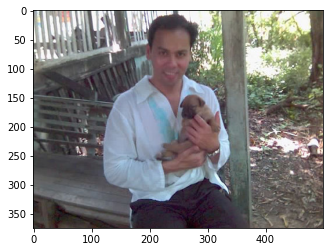

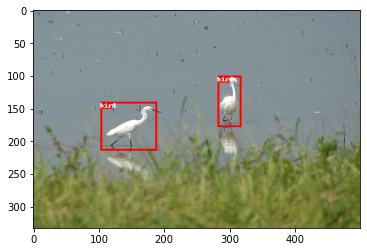

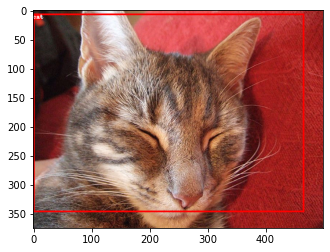

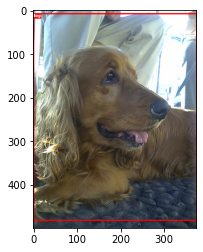

In [76]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
from PIL import Image

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
model.eval()

images, targets, image_ids = next(iter(val_dataloader))

images = list(img.to(device) for img in images)
outputs = model(images)

for i, image in enumerate(images[:4]):

    image = image.permute(1, 2, 0).cpu().numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))

    boxes = outputs[i]["boxes"].data.cpu().numpy()
    scores = outputs[i]["scores"].data.cpu().numpy()
    labels = outputs[i]["labels"].data.cpu().numpy()

    category = dct3

    boxes = boxes[scores >= 0.5].astype(np.int32)
    scores = scores[scores >= 0.5]
    image_id = image_ids[i]

    for i, box in enumerate(boxes):
        draw = ImageDraw.Draw(image)
        label = category[labels[i]]
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        # ラベルの表示
        fnt = ImageFont.truetype("arial.ttf", 10)
        text_w, text_h = fnt.getsize(label)
        draw.rectangle([box[0], box[1], box[0]+text_w, box[1]+text_h], fill="red")
        draw.text((box[0], box[1]), label, fill='white')
    image.save(f"resample_{str(i)}.png")

    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.array(image))